# Processing PPMI datasets to generate a harmonized dataset

### Extract Baseline Data for Patients in the Parkinsons' Cohort from the curated PPMI data

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get the primary data downloaded from PPMI
primary_data = pd.read_excel('../Data/PPMI_Curated_Data_Cut_Public_20240729.xlsx', sheet_name='20240703')

# Filter for EVENT_ID == "BL" and COHORT == 1, which is patients data at baseline and only obtain the Patients from Parkinsons Cohort (1)
filtered_data = primary_data[(primary_data['EVENT_ID'] == 'BL') & (primary_data['COHORT'] == 1)]

# Subset the features to those we determined to be important in the diagnosis of Parkinsons and have shown to be useful for prognosis.
columns_to_keep = [
    'PATNO', 'age', 'EDUCYRS', 'fampd_bin', 'HISPLAT', 'race', 'SEX',
    'APOE', 'APOE_e4', 'urate', 'BMI', 'hy', 'hy_on', 'pigd', 'pigd_on',
    'moca', 'hvlt_retention', 'hvlt_immediaterecall', 'clockdraw',
    'lns', 'lexical', 'TMT_A', 'TMT_B', 'quip', 'stai', 'gds', 'rem',
    'scopa', 'scopa_sex', 'scopa_gi', 'scopa_ur', 'scopa_pm', 'scopa_cv',
    'scopa_therm', 'ptau', 'abeta', 'tau', 'NFL_CSF', 'nfl_serum',
    'sym_tremor', 'sym_rigid', 'sym_brady', 'sym_posins', 'sym_other',
    'duration', 'agediag', 'ageonset', 'cogstate', 'ess', 'hemohi',
    'total_di_18_1_BMP', 'total_di_22_6_BMP', 'asyn', 'mean_caudate',
    'mean_putamen', 'mean_striatum', 'updrs1_score', 'updrs2_score',
    'updrs3_score', 'updrs4_score', 'updrs_totscore', 'pm_adl_any',
    'pm_any', 'pm_auto_any', 'pm_cog_any', 'pm_fd_any', 'pm_mc_any',
    'pm_wb_any', 'Stage_G', 'MSEADLG', 'MODBNT',
    'MODBNT', 'MSEADLG', 'updrs1_score',
    'updrs2_score', 'updrs3_score'
]

# Subset the curated data
subset_data = filtered_data[columns_to_keep]

# export for use
subset_data.to_csv('../Data/dataset_clean_1.csv', index=False)



### Extract Biomarker, Genetic, Lab test data for Patients with PD

In [16]:
# load datasets
saa = pd.read_csv("../Data/SAA_Biospecimen_Analysis_Results_02Oct2024.csv")
biomarker_data = pd.read_csv("../Data/BIOMARKER_DATA.csv")
clinical_data = pd.read_csv("../Data/Blood_Chemistry___Hematology_18Oct2024.csv")
genetic_data = pd.read_csv("../Data/PPMI_PD_Variants_Genetic_Status_WGS_20180921.csv")
family_hist_data = pd.read_csv("../Data/family_history_moca_saa.csv")

dats=pd.read_csv("../Data/DaTScan_SBR_Analysis_02Oct2024.csv")

age = pd.read_csv("../Data/Age_at_visit_02Oct2024.csv")
demo = pd.read_csv("../Data/Demographics_02Oct2024.csv")

In [17]:
##################### Preprocessing Datscan Data #######################
#FILTERING DATSCAN RESULTS TO ONLY SCREENING
dats=dats[dats.EVENT_ID=="SC"]

#Getting specific columns of interest
dats=dats[["DATSCAN_CAUDATE_R", "DATSCAN_CAUDATE_L", "DATSCAN_PUTAMEN_R", "DATSCAN_PUTAMEN_L", "DATSCAN_PUTAMEN_R_ANT", "DATSCAN_PUTAMEN_L_ANT", "PATNO"]]

# MERGING WITH PD, SAA_POSITIVE PATIENTS
dats_SAA = pd.merge(dats, saa[(saa.SAA_Status=="Positive")&(saa.COHORT=="PD")][["PATNO", "SAA_Status"]], on="PATNO", how="inner")

In [18]:
################## Preprocessing Lab Test data ##########################
# ONLY WANT THE CLINICAL DATA at SC
clinical_data=clinical_data[clinical_data.EVENT_ID=="SC"]

# There are some labtest taken at different units. We only will take the last one, since these represent duplicates
clinical_data.drop_duplicates(subset=["PATNO", "LTSTNAME"], keep="last", inplace=True)

# pivot for each patient in each row, and the columns being the different tests being performed for that patient, with the given values being the etest results that that patient obtained for SC visit.
pivot_clinical= clinical_data.pivot(index="PATNO", columns="LTSTNAME", values="LSIRES")
pivot_clinical=pivot_clinical.reset_index()

#drop this column as it seems not to be an actual test
pivot_clinical.drop(["Which visit being performed?"], axis=1, inplace=True)


dats_SAA_clinical_merge=pd.merge(pivot_clinical, dats_SAA, on="PATNO", how="inner")

In [19]:
#################### Preprocessing Biomarker Data ###########################

# Include the suggestions made by sponsor regarding biomarker data
to_test=pd.read_csv("../Data/Select_Biospecimen_Projects_in_PPMI.csv")
biomarkers_data=pd.read_csv("../Data/Current_Biospecimen_Analysis_Results_02Oct2024.csv")

# As sponsor suggested, use data that has spcific testname or belong to project 118. Also filter to only baseline values
biomarkers_data_filt = biomarkers_data.loc[
    ((biomarkers_data["TESTNAME"].isin(to_test["TESTNAME"])) |
    (biomarkers_data["PROJECTID"] == 118)) &
    (biomarkers_data["CLINICAL_EVENT"]=="BL")
]

#  this feature is represente in mutliple units, so just append the unit term
biomarkers_data_filt['TESTNAME'] = biomarkers_data_filt.apply(lambda row: row['TESTNAME'] + ' ' + row['UNITS'] if row['TESTNAME'] == 'pS65 Ubiquitin' else row['TESTNAME'], axis=1)

# Pivot the data, need to get first value, since some values were calculated twice durint the same day presumably, however they seem similar values.
# Possibly done to confirm outlier results
biomarkers_data_filt_pivoted = biomarkers_data_filt.pivot_table(index='PATNO', columns='TESTNAME', values='TESTVALUE', aggfunc='first')

# Reset index to get a clean DataFrame
biomarkers_data_filt_pivoted = biomarkers_data_filt_pivoted.reset_index()

# Save the data
#biomarkers_data_filt_pivoted.to_csv("BIOMARKER_DATA.csv")

#this data is already filtered
dats_SAA_clinical_biomarkers_merge=pd.merge(dats_SAA_clinical_merge, biomarker_data, on="PATNO", how="inner")

/var/folders/hm/t4rw5mt55p71ljdpvv20wdkh0000gn/T/ipykernel_90198/615131162.py:5: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  biomarkers_data=pd.read_csv("data/Current_Biospecimen_Analysis_Results_02Oct2024.csv")
/var/folders/hm/t4rw5mt55p71ljdpvv20wdkh0000gn/T/ipykernel_90198/615131162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biomarkers_data_filt['TESTNAME'] = biomarkers_data_filt.apply(lambda row: row['TESTNAME'] + ' ' + row['UNITS'] if row['TESTNAME'] == 'pS65 Ubiquitin' else row['TESTNAME'], axis=1)


In [20]:
# ##################  ADD GENETIC DATA   ###################################
# NOTE: IF YOU WANT TO KEEP PATIENTS, DO NOT ADD THE GENETIC DATA AND EXPORT TO SCV RIGHT HERE
# dats_SAA_clinical_biomarkers_merge.to_csv("DATA_WITHOUT_GENETIC.csv")
dats_SAA_clinical_biomarkers_merge_genetic_merge=pd.merge(dats_SAA_clinical_biomarkers_merge, genetic_data, on="PATNO", how="inner")

In [21]:
##################### ADD AGE AND SEX OF PATIENTS #########################
#Remove duplicate
dats_SAA_clinical_biomarkers_merge_genetic_merge.drop_duplicates(inplace=True)

# ADD AGE OF PATIENT at EVENT_ID ==SC (Age at screening time)
dats_SAA_clinical_biomarkers_merge_genetic_merge=pd.merge(dats_SAA_clinical_biomarkers_merge_genetic_merge, age[age.EVENT_ID =="SC"][["PATNO", "AGE_AT_VISIT"]], how="inner", on="PATNO")

# ADD PATIENT SEX COLUMN
dats_SAA_clinical_biomarkers_merge_genetic_merge=pd.merge(dats_SAA_clinical_biomarkers_merge_genetic_merge, demo[demo.PAG_NAME =="SCREEN"][["PATNO", "SEX"]], how="inner", on="PATNO")

In [22]:
###################### ADD the moca score of the patients at Screening time ############################
# THIS COULD ALSO BE A GOOD PREDICTOR
moca_data_tot = pd.read_csv("../Data/Montreal_Cognitive_Assessment__MoCA__02Oct2024.csv")

moca_data_tot=moca_data_tot[['PATNO', 'EVENT_ID', 'MCAALTTM',
       'MCACUBE', 'MCACLCKC', 'MCACLCKN', 'MCACLCKH', 'MCALION', 'MCARHINO',
       'MCACAMEL', 'MCAFDS', 'MCABDS', 'MCAVIGIL', 'MCASER7', 'MCASNTNC',
       'MCAVFNUM', 'MCAVF', 'MCAABSTR', 'MCAREC1', 'MCAREC2', 'MCAREC3',
       'MCAREC4', 'MCAREC5', 'MCADATE', 'MCAMONTH', 'MCAYR', 'MCADAY',
       'MCAPLACE', 'MCACITY', 'MCATOT']]
#filter moca to only at screening time
moca_data_tot=moca_data_tot[moca_data_tot.EVENT_ID=="SC"]

dats_SAA_clinical_biomarkers_merge_genetic_merge=pd.merge(dats_SAA_clinical_biomarkers_merge_genetic_merge, moca_data_tot, how="inner", on="PATNO")

In [23]:
##################### ADD THE FAMILY HISTORY DATA ################################################
#family history is already at EVENT_ID==SC
family_hist_data=pd.read_csv("../Data/Family_History_02Oct2024.csv")
family_hist_data=family_hist_data[family_hist_data.EVENT_ID=="SC"]

#Preselected features
family_hist_data=family_hist_data[['ANYFAMPD', 'BIOMOM',
       'BIOMOMPD', 'BIODAD', 'BIODADPD', 'FULSIB', 'FULBRO', 'FULSIS',
       'FULSIBPD', 'FULBROPD', 'FULSISPD', 'HAFSIB', 'PAHAFSIB', 'MAHAFSIB',
       'HAFSIBPD', 'MAHAFSIBPD', 'PAHAFSIBPD', 'MAGPAR', 'MAGPARPD',
       'MAGFATHPD', 'MAGMOTHPD', 'PAGPAR', 'PAGPARPD', 'PAGFATHPD',
       'PAGMOTHPD', 'MATAU', 'MATAUPD', 'PATAU', 'PATAUPD', 'KIDSNUM',
       'KIDSPD', 'DISFAMPD', 'MATCOUS', 'MATCOUSPD', 'PATCOUS', 'PATCOUSPD', "PATNO"]]

dats_SAA_clinical_biomarkers_merge_genetic_family_merge=pd.merge(dats_SAA_clinical_biomarkers_merge_genetic_merge, family_hist_data, how="left", on="PATNO")

dats_SAA_clinical_biomarkers_merge_genetic_family_merge.drop_duplicates(inplace=True)

In [24]:
##################### Precleaning: REMOVE COLUMNS WITH HIGH MISSING DATA ###########################

# threshold for data missingness
nan_threshold = 0.7
# get the min non-nan numbers of cols
min_non_nan = int((1 - nan_threshold) * len(dats_SAA_clinical_biomarkers_merge_genetic_family_merge))

#get the cleaner data
clean_merged_data=dats_SAA_clinical_biomarkers_merge_genetic_family_merge.dropna(axis=1, thresh=min_non_nan)

In [25]:
####################### SAVE Biomarker, genetic, LAB TEST DATA  ###################################################
clean_merged_data.drop("Unnamed: 0", axis=1, inplace=True)
#clean_merged_data.to_csv("MERGED_DATA_10202024_DS_UPDATE3_WITH_INDIVIDUAL_MOCA_AND_FAMILIYHIST.csv")

/var/folders/hm/t4rw5mt55p71ljdpvv20wdkh0000gn/T/ipykernel_90198/2997956422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_merged_data.drop("Unnamed: 0", axis=1, inplace=True)


# LABEL GENERATION

### Preparing MOCA SCORES Overtime dataset (Label Generation done by collaborator Alejandro Cruz)

In [4]:
##################################################   GET SCORES OVERTIME OF THE PATIENTS IN ORDER TO FIT LINEAR MODELS ##############
import pandas as pd
# in BOX file, which a filtered list of patients who meets Charles requirements: SAA status column, patients are part of PD cohort. 
moca_data = pd.read_csv('../Data/Montreal_Cognitive_Assessment__MoCA__02Oct2024.csv')
saa = pd.read_csv('../Data/SAA_Biospecimen_Analysis_Results_02Oct2024.csv')

#some patiens have two measurements= first was inconclusive, therefore keep the last measurement done
saa=saa.drop_duplicates(subset=["PATNO", "CLINICAL_EVENT"], keep="last")
# merging on patient number
saa_moca_merge = pd.merge(moca_data[["PATNO", "MCATOT", "EVENT_ID", "INFODT"]],saa[(saa["COHORT"]=="PD")&(saa["CLINICAL_EVENT"]=="BL")&(saa["SAA_Status"]=="Positive")][["PATNO", "SAA_Status", "COHORT"]] , on="PATNO", how="inner")

# get only PATNOs with EVENT_ID == "SC", since we need a baseline
patno_with_sc = saa_moca_merge[saa_moca_merge["EVENT_ID"] == "SC"]["PATNO"].unique()

# filter the data on those patients
saa_moca_merge = saa_moca_merge[saa_moca_merge["PATNO"].isin(patno_with_sc)]

# counts the number of events per patients
event_counts = saa_moca_merge.groupby('PATNO').size().reset_index(name='event_count')

# only those patients with more or equal to 3 events
patno_with_3_events = event_counts[event_counts['event_count'] >= 3]['PATNO']

# filter data based on thos patients
saa_moca_merge = saa_moca_merge[saa_moca_merge["PATNO"].isin(patno_with_3_events)]

# MAP THE VISITS DATE TO THE TIME SINCE FIRST CONTACT WITH PATIENT.
# FOR EXAMPLE, FOR A PATIENT WHO FIRST VISIT SC WAS 01/2023, THE 4th VISIT ON 01/2024 WILL HAVE A RECORD OF 365 days.

# convert to pandas date format
saa_moca_merge['VISIT_DATE'] = pd.to_datetime(saa_moca_merge['INFODT'])

# get the data when screening actually happened
baseline_dates = saa_moca_merge[saa_moca_merge['EVENT_ID'] == 'SC'][['PATNO', 'VISIT_DATE']]
baseline_dates = baseline_dates.rename(columns={'VISIT_DATE': 'SC_DATE'})

# merge the baseline dates
saa_moca_merge = pd.merge(saa_moca_merge, baseline_dates, on='PATNO', how='inner')

# get the time since baseline/screening visit in days for each patient
saa_moca_merge['DAYS_SINCE_SC'] = (saa_moca_merge['VISIT_DATE'] - saa_moca_merge['SC_DATE']).dt.days

ind_to_drop = saa_moca_merge[saa_moca_merge["DAYS_SINCE_SC"] < 0].index
saa_moca_merge = saa_moca_merge.drop(ind_to_drop).reset_index(drop=True)

# import the participation status data
# merge on enrollment , because we want ot obtain the age of the patient
status=pd.read_csv('../Data/Participant_Status_02Oct2024.csv')
saa_moca_merge = pd.merge(saa_moca_merge, status[["PATNO", "ENROLL_AGE"]], on=["PATNO"], how="inner")

# import the demographics patients of each patient
# merge on sex
sex_data = pd.read_csv('../Data/Demographics_02Oct2024.csv')

saa_moca_sex_merge  = pd.merge(saa_moca_merge, sex_data[["PATNO", "SEX"]], on=["PATNO"], how="inner")

#saa_moca_sex_merge.drop_duplicates()
# Extract the data to only the first 2191 days, or 6 years for ech patient
df_MOCA_2191_days=saa_moca_sex_merge[(saa_moca_sex_merge["DAYS_SINCE_SC"]<=2191)]

#df_MOCA_2191_days.to_csv("Data/Filtered_data_with_clusters__2190_Days.csv")

C:\Users\15855\AppData\Local\Temp\ipykernel_100556\3079242387.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  saa_moca_merge['VISIT_DATE'] = pd.to_datetime(saa_moca_merge['INFODT'])


### Fitting a slope to patients with more than two MoCA observations

In [41]:
from statsmodels.formula.api import ols
df_path = "../Data/Filtered_data_with_clusters__2190_Days.csv"
df = pd.read_csv(df_path)
df = df.rename(columns={'cluster': 'cluster_dennis'})

# Filter out patients with fewer than 2 observations
patient_counts = df.groupby('PATNO').size().reset_index(name='Count')
valid_patients = patient_counts[patient_counts['Count'] >= 2]['PATNO']
df_valid = df[df['PATNO'].isin(valid_patients)]

# Function to fit linear model and extract slope
def fit_linear_model(group):
    model = ols('MCATOT ~ DAYS_SINCE_SC', data=group).fit()
    slope = model.params['DAYS_SINCE_SC']
    return slope

# Apply the model to each patient group and extract the slope
slopes = df_valid.groupby('PATNO').apply(fit_linear_model).reset_index(name='Slope')

print(slopes)

      PATNO     Slope
0      3001 -0.000283
1      3002 -0.002067
2      3003  0.000790
3      3010  0.000967
4      3012 -0.002764
..      ...       ...
655  214900 -0.003451
656  217633 -0.001562
657  218338 -0.004422
658  219605  0.004225
659  238871  0.002146

[660 rows x 2 columns]


/var/folders/hm/t4rw5mt55p71ljdpvv20wdkh0000gn/T/ipykernel_90198/1431398230.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes = df_valid.groupby('PATNO').apply(fit_linear_model).reset_index(name='Slope')


### Selecting a patient as an example

                            OLS Regression Results                            
Dep. Variable:                 MCATOT   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.238
Method:                 Least Squares   F-statistic:                   0.03718
Date:                Wed, 11 Dec 2024   Prob (F-statistic):              0.856
Time:                        18:35:15   Log-Likelihood:                -13.195
No. Observations:                   6   AIC:                             30.39
Df Residuals:                       4   BIC:                             29.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        27.1443      1.947     13.940

/Users/veronicamataramirez/miniforge3/envs/deeplearning/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


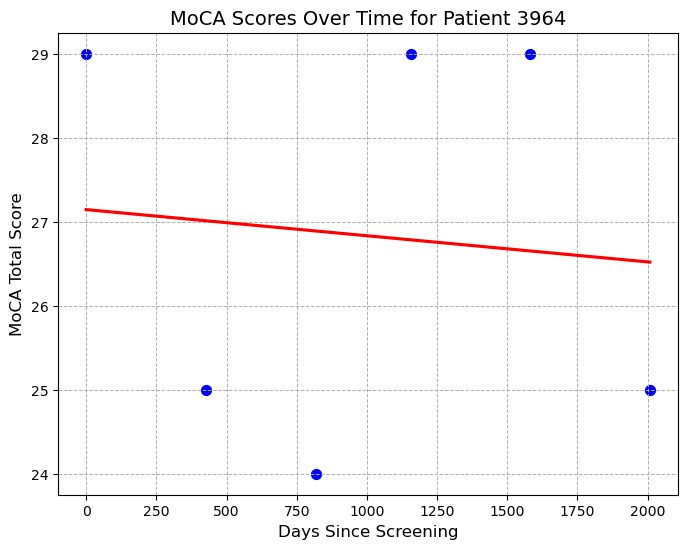

In [42]:
# Selecting a random patient
random_patient_id = df_valid['PATNO'].drop_duplicates().sample(n=1, random_state=123).values[0]

# Extract data for the random patient
patient_data = df_valid[df_valid['PATNO'] == random_patient_id]

# Fit a linear model for the patient's data
patient_model = ols('MCATOT ~ DAYS_SINCE_SC', data=patient_data).fit()
print(patient_model.summary())


plt.figure(figsize=(8, 6))
# Scatter plot of the patient's data
plt.scatter(patient_data['DAYS_SINCE_SC'], patient_data['MCATOT'], color='blue', s=50)
# Plot the regression line
sns.regplot(x='DAYS_SINCE_SC', y='MCATOT', data=patient_data, scatter=False, color='red', ci=None)

plt.title(f"MoCA Scores Over Time for Patient {random_patient_id}", fontsize=14)
plt.xlabel("Days Since Screening", fontsize=12)
plt.ylabel("MoCA Total Score", fontsize=12)

# Minimal theme
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.show()

### Splitting patients based on 0.0014 threshold

In [43]:
# Define a clinically meaningful threshold (in this case as advised by our sponsor, Charles)
threshold = -0.0014  # Adjust based on clinical input

# Assign labels based on the threshold
slopes['Label'] = slopes['Slope'].apply(lambda x: 1 if x <= threshold else 0)

# Recount the labels
label_counts = slopes['Label'].value_counts().reset_index()
label_counts.columns = ['Label', 'Count']

print(label_counts)
slopes.to_csv('../Data/slopes_0.0014.csv', index = False)

   Label  Count
0      0    530
1      1    130


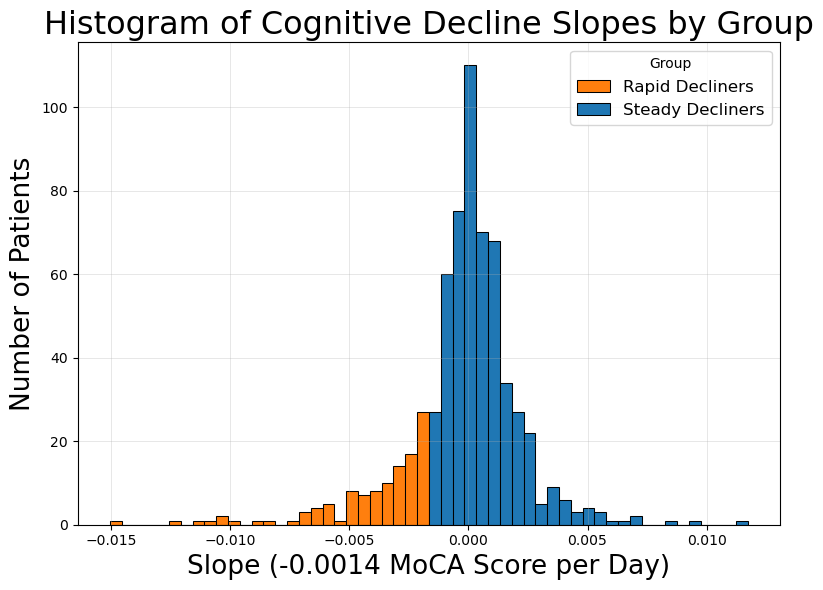

In [44]:
# Create a histogram of slopes, colored by label
plt.figure(figsize=(8, 6))
sns.histplot(data=slopes, x='Slope', hue='Label', bins=30, binwidth=0.0005,
              edgecolor='black', alpha=1)
plt.title("Histogram of Cognitive Decline Slopes by Group", fontsize=23)
plt.xlabel("Slope (-0.0014 MoCA Score per Day)", fontsize=19)
plt.ylabel("Number of Patients", fontsize=19)
plt.legend(title='Group', labels=['Rapid Decliners', 'Steady Decliners'], fontsize=12)
plt.grid(True, which='both', linestyle='-', linewidth=0.7, alpha=0.3)
plt.tight_layout()
plt.show()

# DATA MERGING AND PREPROCESSING/CLEANING

In [31]:
#################################### LOAD THE DATASETS CREATED ABOVE AND MERGE ############################################
import numpy as np
import pandas as pd

data_to_merge = pd.read_csv("../Data/dataset_clean_medications.csv") # Vero's merged dataset
slopes = pd.read_csv("../Data/slopes_0.0014.csv") # -0.0014 slope patient split

# same as before, the dataset with medication, merged with new slopes
merged_data = pd.merge(data_to_merge, slopes[['PATNO', 'Label']], on='PATNO', how='inner')

# the clinical data
clinical_bm_data= pd.read_csv("../Data/MERGED_DATA_10202024_DS_UPDATE3_WITH_INDIVIDUAL_MOCA_AND_FAMILIYHIST.csv")



In [32]:
# drop the common columns
import pandas as pd

# there are common features, so delete them form the clinical if present
common_columns = set(merged_data.columns).intersection(set(clinical_bm_data.columns)) - set(["PATNO"])  # Replace "key_column" with the column to merge on
df2_filtered = clinical_bm_data.drop(columns=common_columns, errors="ignore")

# do inner merge
merged_df = pd.merge(merged_data, df2_filtered, how="inner", on="PATNO")  # Replace "key_column" with your actual key column

merged_df.Label.value_counts()


Label
0    295
1     75
Name: count, dtype: int64

### Cleaning rows and columns with high missing data

In [33]:
# Cleaning columns
#assessing the Nan percentage on the columns
nan_percentage = (merged_df.isna().sum() / len(merged_df)) * 100

nan_percentage_sorted = nan_percentage.sort_values(ascending=False)
# Threshold for missing data
threshold = 40
# Identify columns to drop
columns_to_drop = nan_percentage[nan_percentage > threshold].index

# Drop the columns
merged_data_cleaned = merged_df.drop(columns=columns_to_drop)


In [34]:
# Cleaning rows
# Set the threshold for row-wise missing data percentage
row_threshold = 15

# Calculate the percentage of missing data for each row
row_nan_percentage = (merged_data_cleaned.isna().sum(axis=1) / merged_data_cleaned.shape[1]) * 100

# Identify rows to keep (those with less than the threshold of missing data)
rows_to_keep = row_nan_percentage < row_threshold

# Filter the DataFrame
df_cleaned_rows = merged_data_cleaned[rows_to_keep]

print(f"Removed rows: {len(merged_data_cleaned) - len(df_cleaned_rows)}")
print(len(df_cleaned_rows))

Removed rows: 55
315


In [35]:
df_cleaned_rows.Label.value_counts()

Label
0    252
1     63
Name: count, dtype: int64